<a href="https://colab.research.google.com/github/ccrader/python_projects/blob/main/Fine_Tuning_Code_Along_Dataset_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets transformers sentence_transformers faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00


In [2]:
from google.colab import userdata

hf_token = userdata.get('huggingface')

In [3]:
from datasets import load_dataset

# Open platypus dataset combines multiple datasets used for fine-tuning llm models
# for answering technical math, science, coding, and other questions
dataset = load_dataset('garage-bAInd/Open-Platypus')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.34k [00:00<?, ?B/s]

(…)-00000-of-00001-4fe2df04669d1669.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [4]:
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

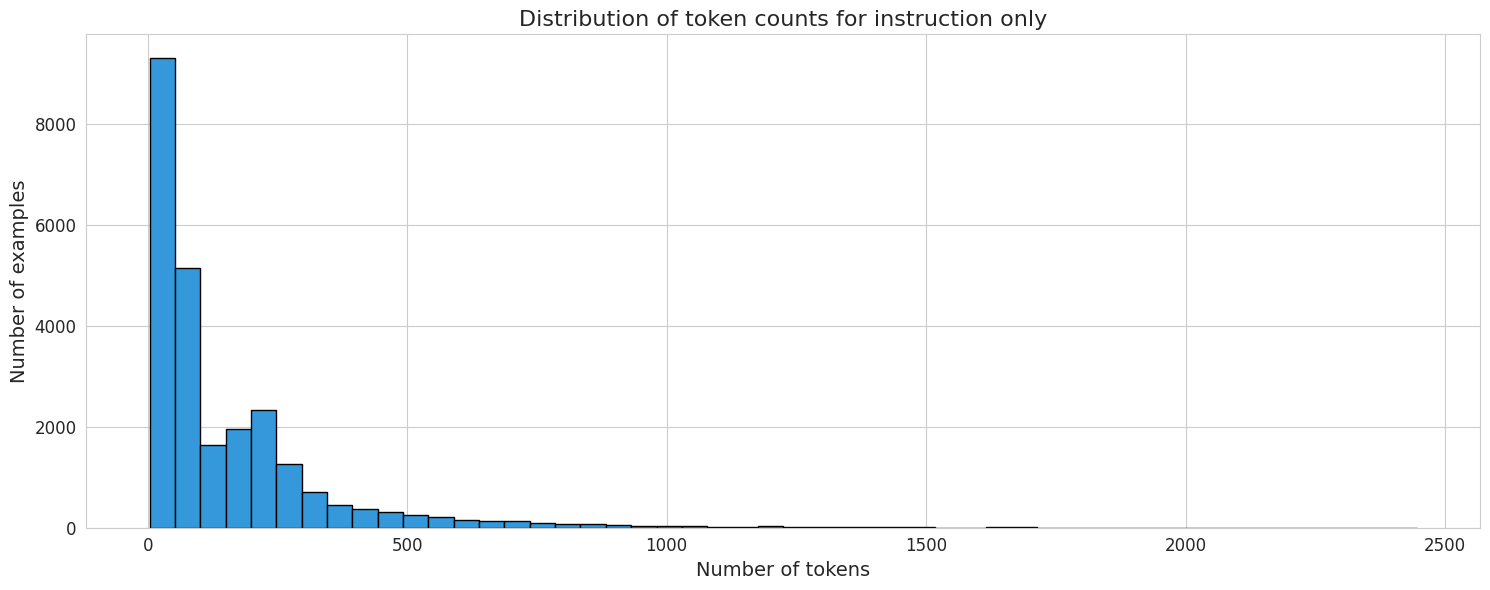

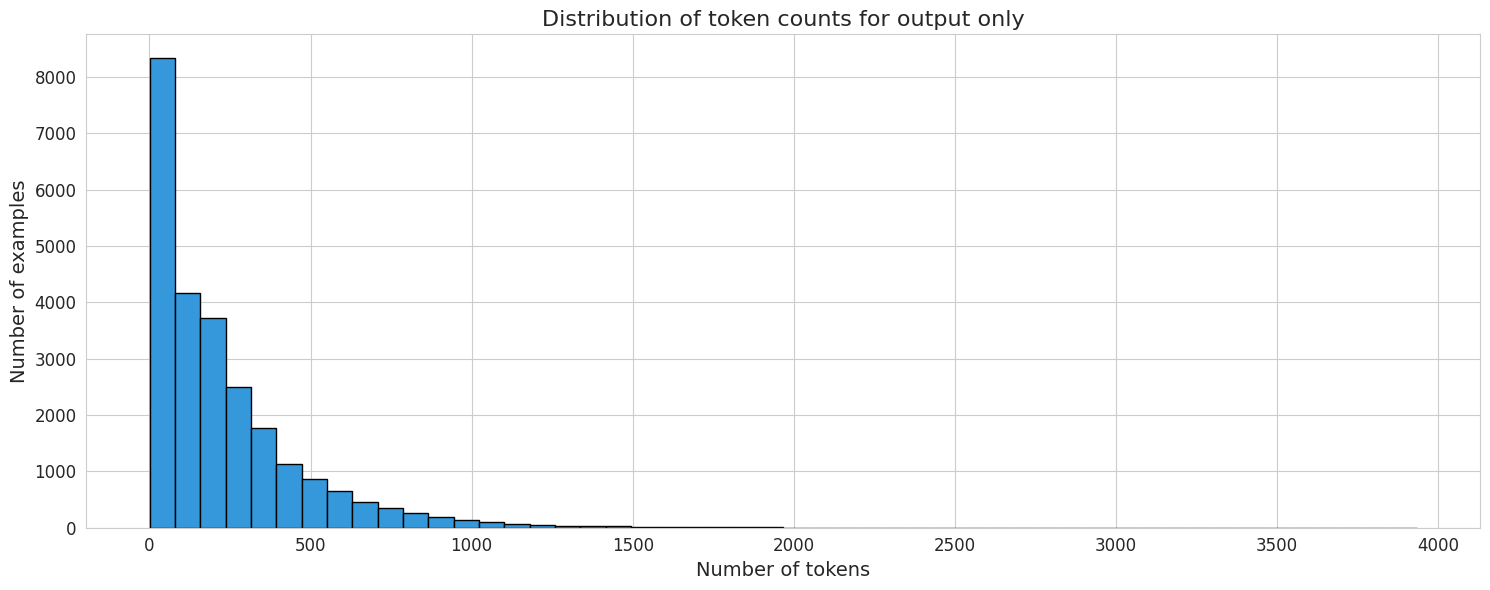

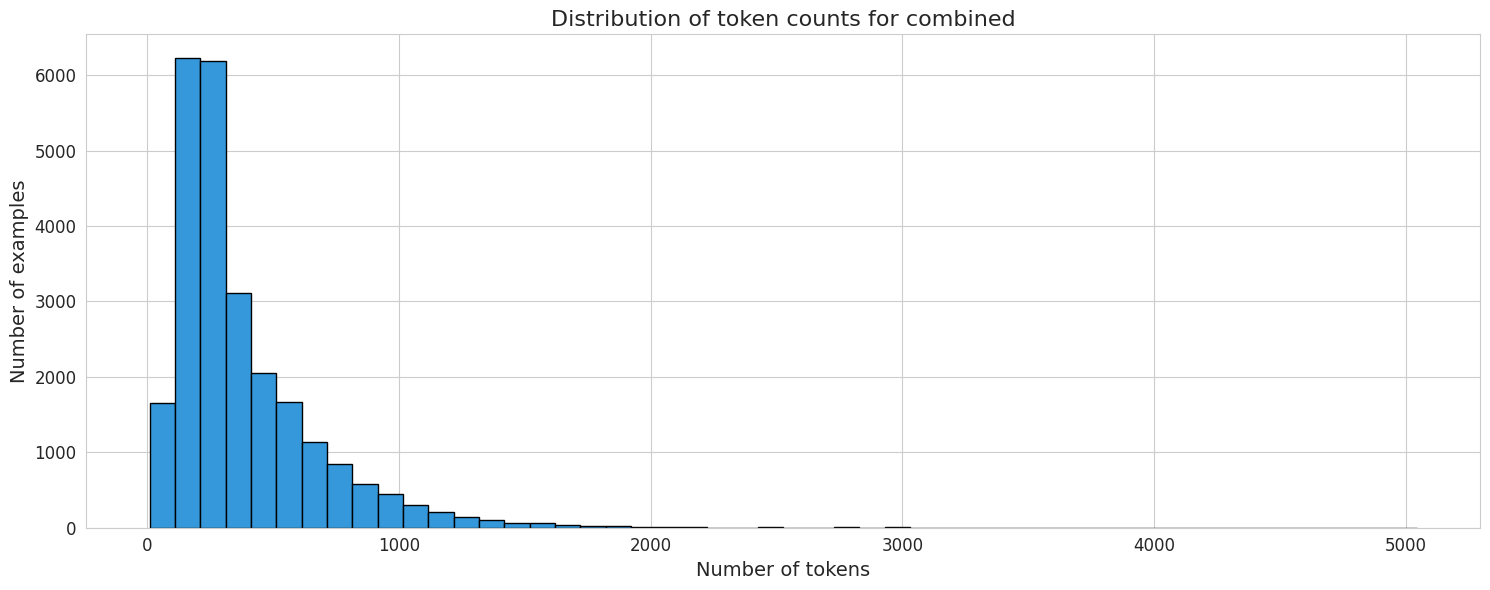

In [5]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-hf')

instruction_token_counts = [len(tokenizer.tokenize(example['instruction'])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example['output'])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

def plot_distribution(token_counts, title):
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


plot_distribution(instruction_token_counts, 'Distribution of token counts for instruction only')
plot_distribution(output_token_counts, 'Distribution of token counts for output only')
plot_distribution(combined_token_counts, 'Distribution of token counts for combined')

24895
31


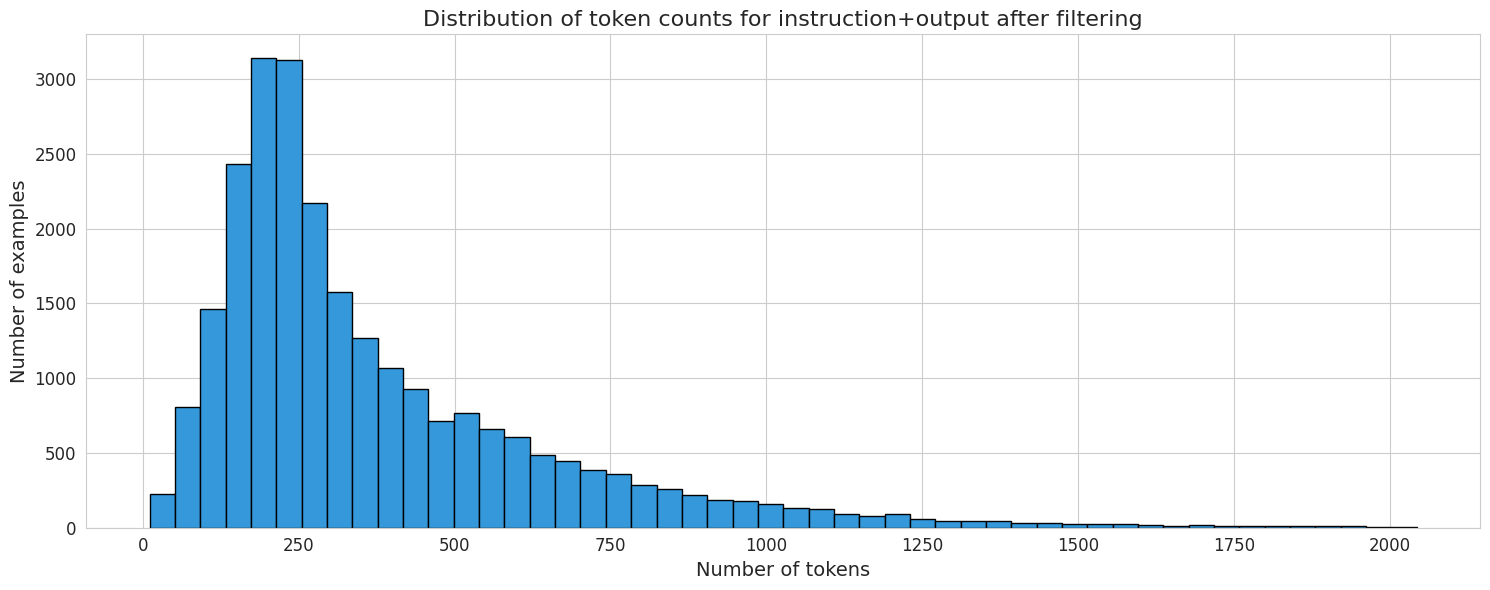

In [6]:
# Filter out rows with more than 2048 tokens

valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(len(valid_indices))
print(len(dataset['train']) - len(valid_indices))

dataset['train'] = dataset['train'].select(valid_indices)

token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "Distribution of token counts for instruction+output after filtering")

In [7]:
# MTEB Leaderboard gives best embedding models
# We won't use the best because it would take too long. gte-base instead

from sentence_transformers import SentenceTransformer
import faiss #simple vector database
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, 'thenlper/gte-large', 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [8]:
print(len(dataset['train']))
print(len(deduped_dataset['train']))
print(len(dataset['train']) - len(deduped_dataset['train']))

24895
18161
6734


In [9]:
# Top-k sampling
# Only keep the top k samples with the most tokens

def get_top_k_rows(dataset, token_counts, k):
  sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
  top_k_indices = sorted_indices

  top_k_data = {
      'instruction': [dataset['train'][i]['instruction'] for i in top_k_indices],
      'output' : [dataset['train'][i]['output'] for i in top_k_indices]
  }

  return Dataset.from_dict(top_k_data)


instruction_token_counts = [len(tokenizer.tokenize(example['instruction'])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example['output'])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k)

dataset = DatasetDict({'train' : top_k_dataset})

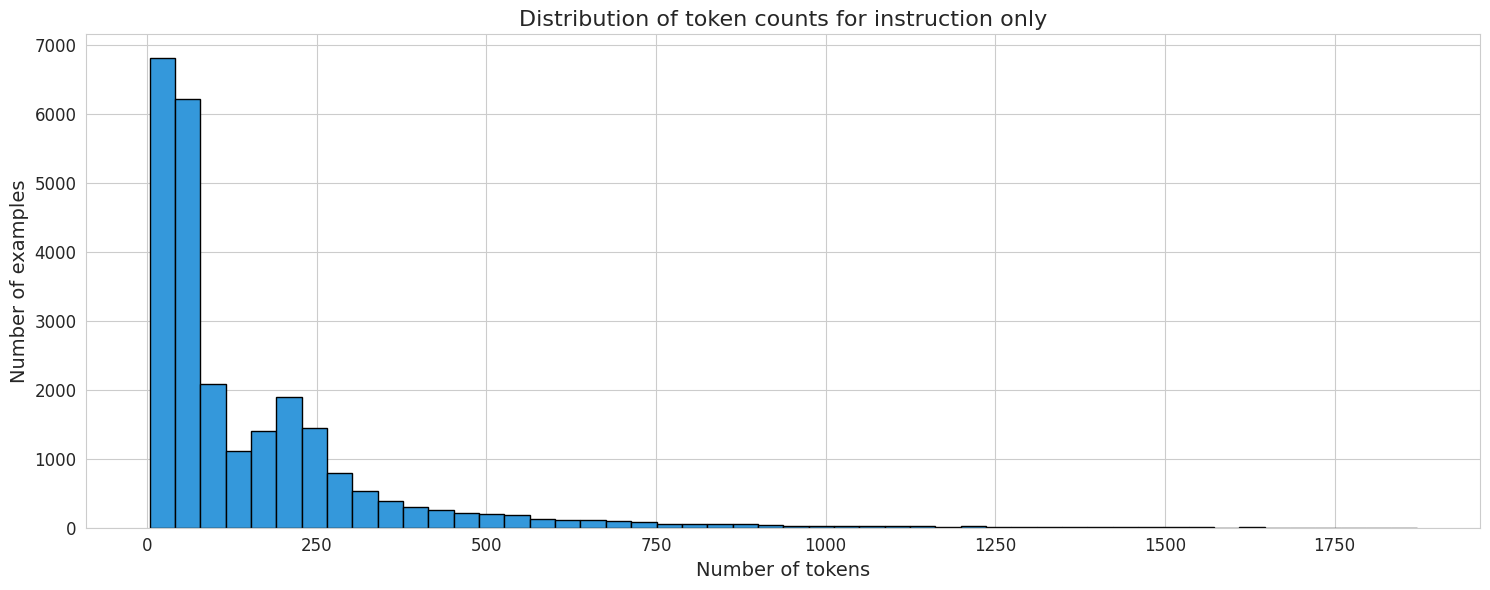

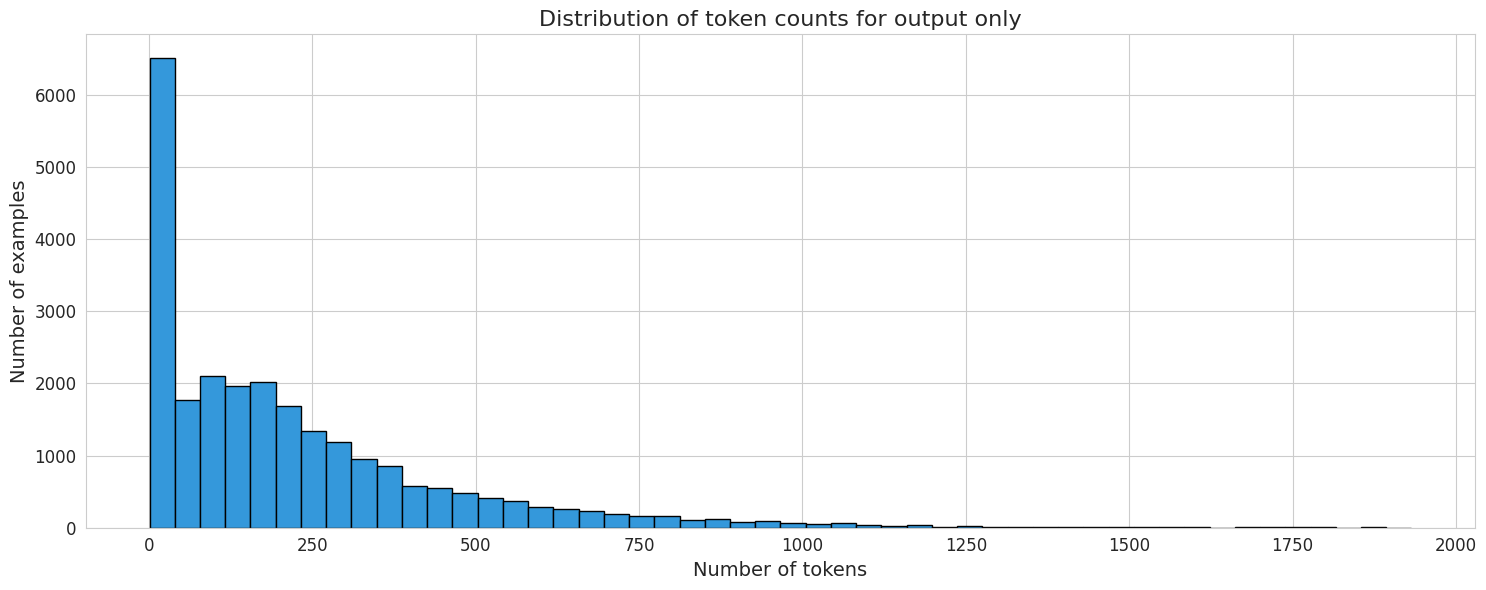

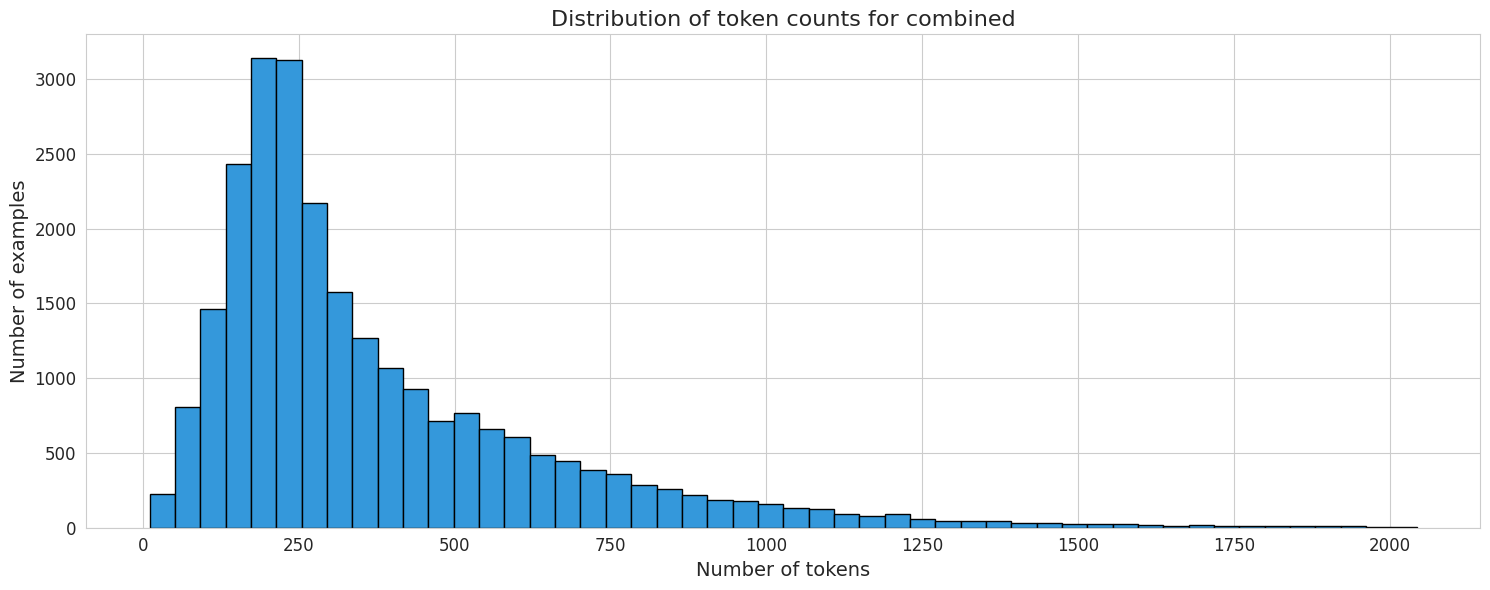

In [10]:
instruction_token_counts = [len(tokenizer.tokenize(example['instruction'])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example['output'])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

plot_distribution(instruction_token_counts, 'Distribution of token counts for instruction only')
plot_distribution(output_token_counts, 'Distribution of token counts for output only')
plot_distribution(combined_token_counts, 'Distribution of token counts for combined')

In [11]:
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
24890,"The quality of sound, and an anagram of ""note"".",tone
24891,The chemical formula for water is ___.\n,H₂O
24892,"In mathematics, what is the only even prime nu...",2
24893,What is the smallest prime number? ___\n,2


In [12]:
# Chat templates
# Need to define a chat template to use the LLM as a chatbot

# In the case of LLama 2, there is a complicated chat syntax that we don't need to use
# since we're using the base model not the chat function

def chat_template(example):
  example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
  return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

In [13]:
# Optional: push to Hugging Face Hub
dataset.push_to_hub("mini-platypus", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ccrader/mini-platypus/commit/6cbc83cfe042b91d406e5556a71a54781af6df4c', commit_message='Upload dataset', commit_description='', oid='6cbc83cfe042b91d406e5556a71a54781af6df4c', pr_url=None, pr_revision=None, pr_num=None)